## Importing Packages

In [4]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Model Setup

Trying with timestep 0.31746031746031744 kyr
assigning left boundary temperature 273.0
[-60.120240480961925, 60.120240480961925, 180.3607214428858, 300.6012024048096, 420.8416833667335, 541.0821643286572, 661.3226452905812, 781.5631262525051, 901.8036072144289, 1022.0440881763526, 1142.2845691382763, 1262.5250501002004, 1382.7655310621244, 1503.006012024048, 1623.246492985972, 1743.4869739478956, 1863.7274549098197, 1983.9679358717435, 2104.208416833667, 2224.4488977955907, 2344.689378757515, 2464.9298597194393, 2585.1703406813626, 2705.4108216432865, 2825.6513026052107, 2945.8917835671346, 3066.132264529058, 3186.3727454909817, 3306.613226452906, 3426.85370741483, 3547.094188376753, 3667.334669338677, 3787.5751503006013, 3907.815631262525, 4028.056112224449, 4148.296593186373, 4268.537074148296, 4388.77755511022, 4509.018036072144, 4629.258517034068, 4749.498997995992, 4869.739478957917, 4989.97995991984, 5110.220440881763, 5230.460921843687, 5350.701402805611, 5470.941883767535, 5591

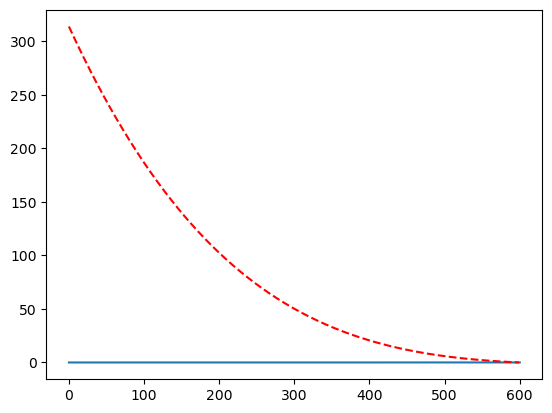

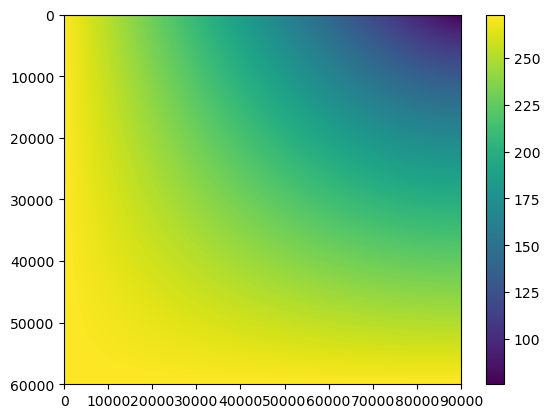

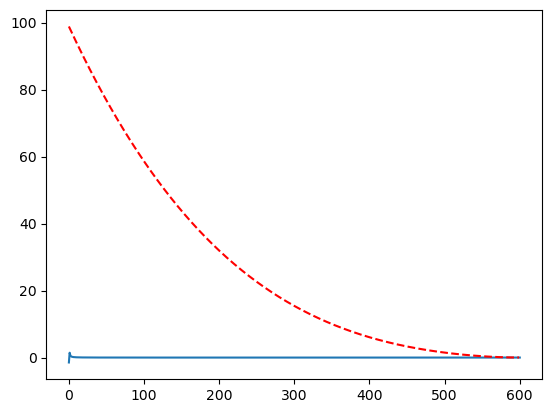

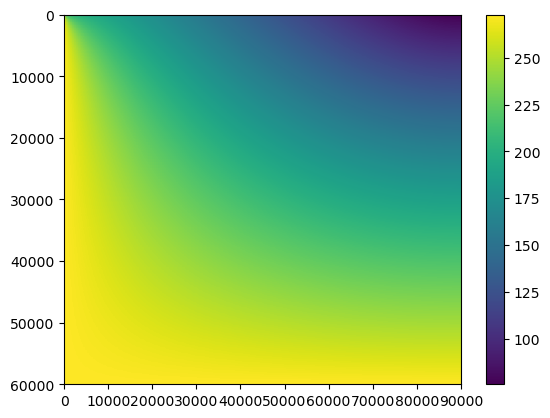

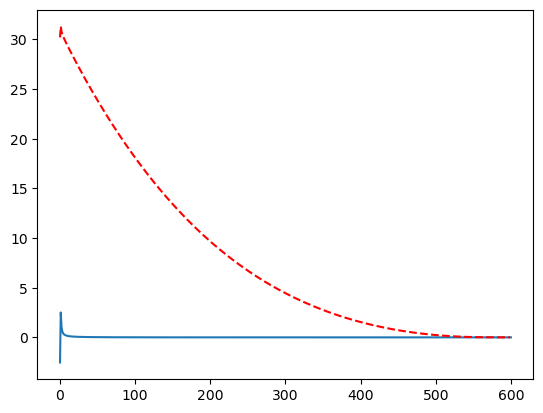

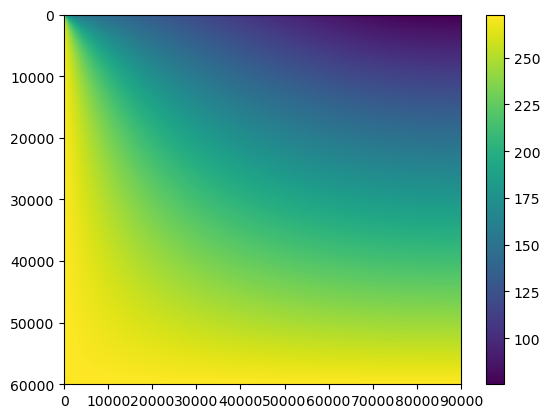

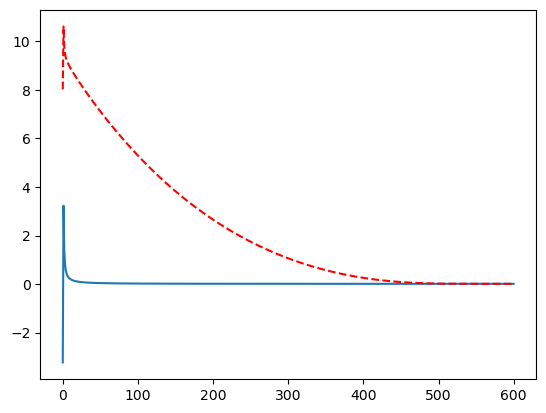

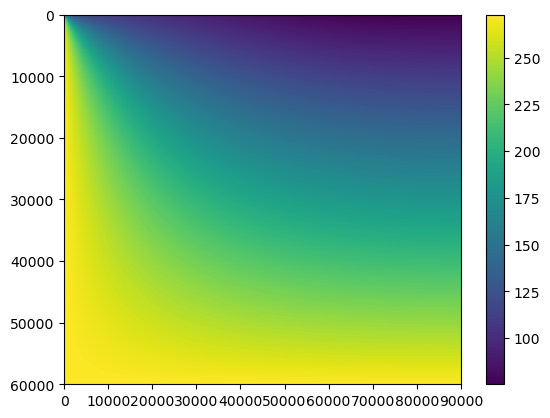

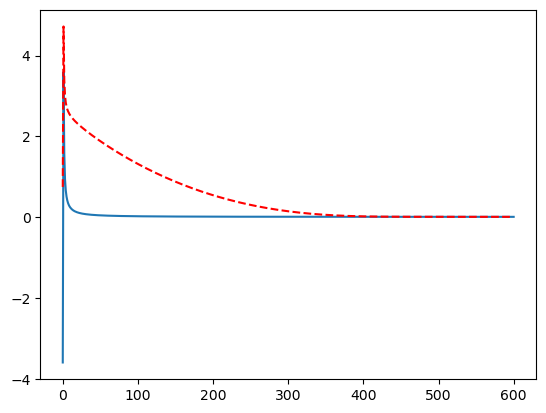

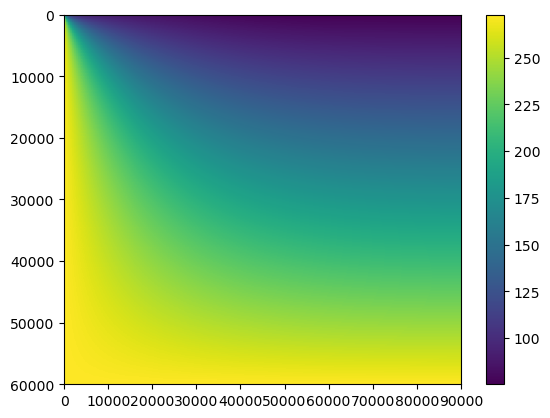

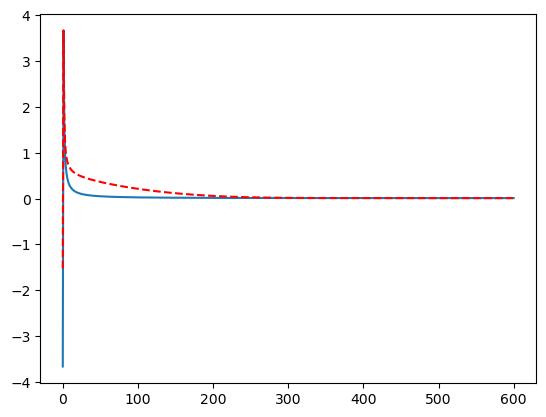

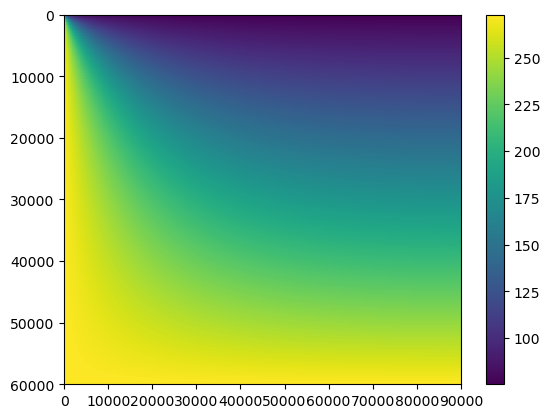

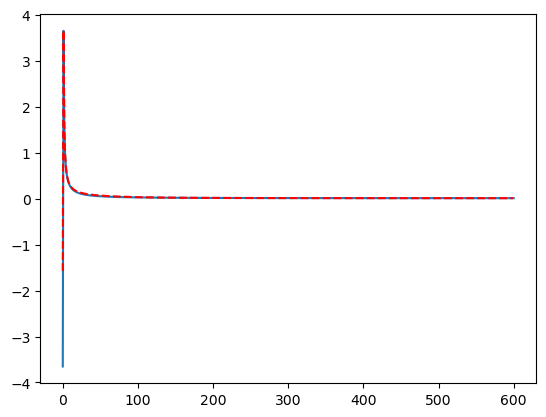

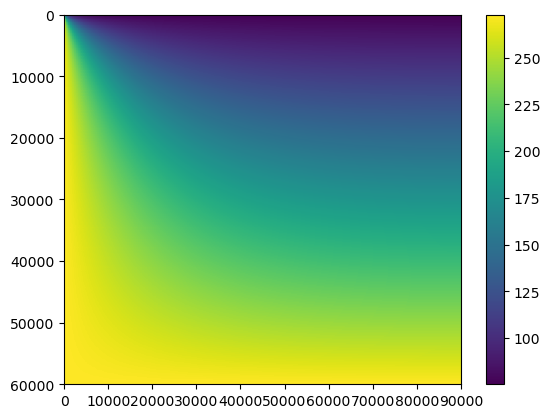

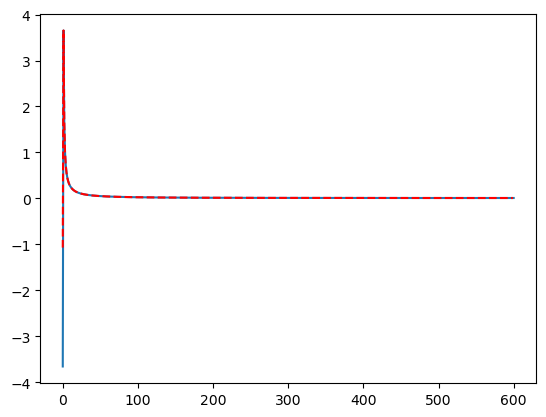

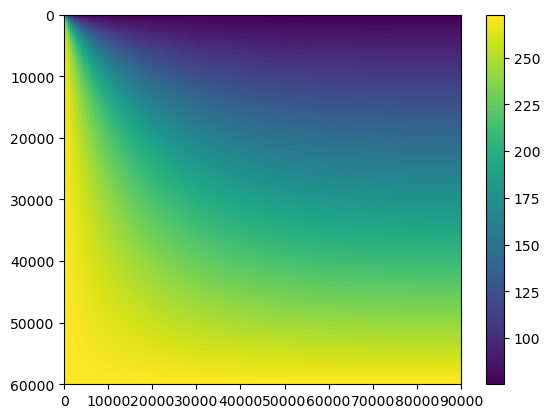

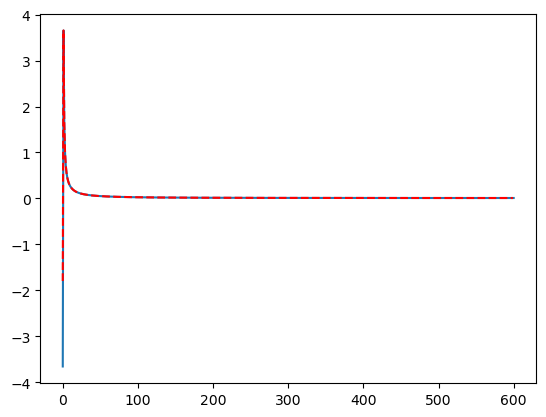

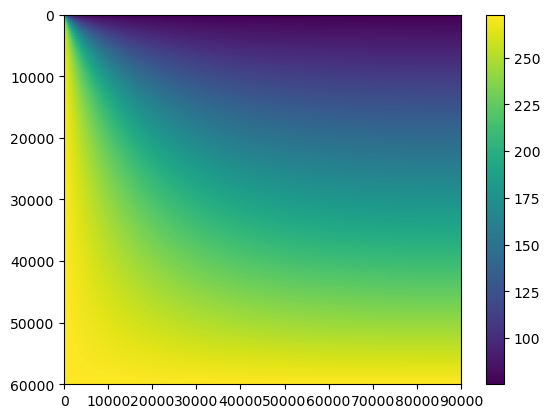

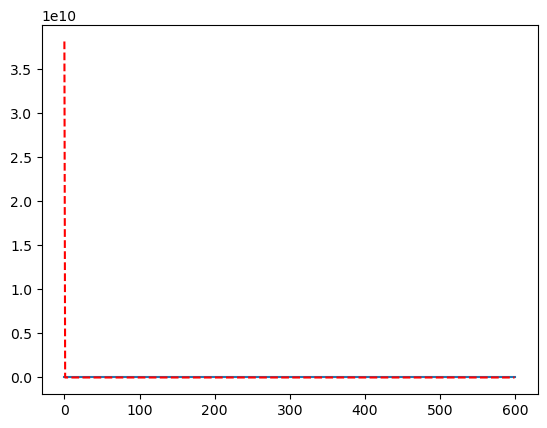

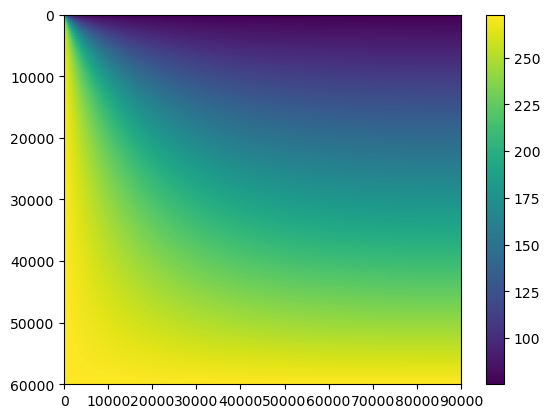

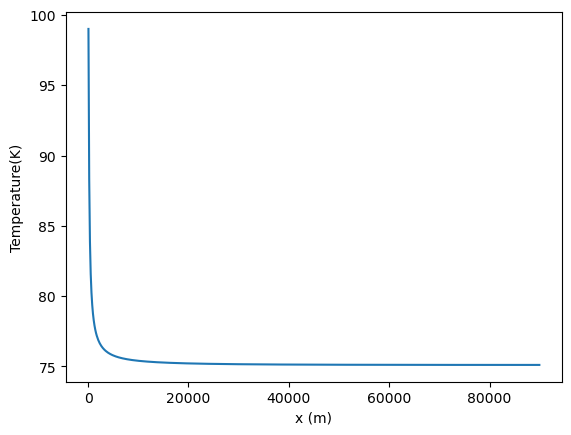

In [35]:
function run(;max_time::Float64,max_step::Int64)
    nx = 600
    ny = 500
    W = 90000.0
    H = 60000.0
    gx = 0.0
    gy = 1.3
    
    Tbctype = [1,-1,1,1] #left, right, top, bottom
    Tbcval = [273.0,0.0,75.0,273.0] #left, right, top, bottom
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    
    Tsurf = zeros(Float64,grid.nx)
    for j in 1:grid.nx
       Tsurf[j] = 273.0 - (273.0-75.0)*grid.xc[j]/grid.W 
    end
    
    ### Setting up agruments for termination criteria ###
    max_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step
    
    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10
    
    # Localaztion 
    local rho_c  
    local Cp_c 
    local Tlast 
    local kThermal
    local dTmax
    local dTemp
    local Tnew
    local R

    itime = 1
    output_dir = "test"
    
    local BoltzmannConstant = 5.67e-8 # W/m^2*K^4
    local qIn = (1)*(BoltzmannConstant)*(75.0)^4 # W/m^2
    rho_c = 1000.0*ones(grid.ny+1,grid.nx+1)
    Cp_c = 2100.0*ones(grid.ny+1,grid.nx+1)
    kThermal = 3.0*ones(grid.ny+1,grid.nx+1)
    Tlast = zeros(grid.ny+1,grid.nx+1)
    H = zeros(grid.ny+1,grid.nx+1)
    
    terminate = false
    for titer = 1:10
        
        # 1. Assume a T(x) at surface 
        # 2. Sovlve T(x,y)
        # 3. Compute q_surf 
        # 4. Update T 

        println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
        L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval,Tsurf)
        Tnew = L\R;

        Tnew = reshape(Tnew,grid.ny,grid.nx);
        Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval,Tsurf)
        q_surf= kThermal[1,1]*(Tnew[2,:]-Tnew[1,:])/(grid.yc[2] - grid.yc[1]) 
        # q_surf = kThermal*(Tnew[2,:] - Tnew[1,:])/(grid.yc[2] - grid.yc[1])
        q_rad = BoltzmannConstant.*Tsurf.^4 .- qIn
        
        println(grid.yc)
        figure()
        plot(q_surf)
        plot(q_rad,"r--")
        show()
        
        residual = q_surf[1:grid.nx] - (BoltzmannConstant.*Tsurf.^4 .- qIn)
        figure()
        pcolor(grid.xc[2:grid.nx],grid.yc[2:grid.ny],Tnew[2:grid.ny,2:grid.nx])            
        colorbar()
        gca().invert_yaxis()
        show()
        println(size(Tsurf))
        dRdT = 4*BoltzmannConstant.*Tsurf.^3
        Tsurf = Tsurf + residual./dRdT
 
    end
    return grid,Tnew
end
@time grid,Tnew = run(max_time=-1.0,max_step=2)

figure()
plot(grid.xc[2:grid.nx],(Tnew[2,2:grid.nx]+Tnew[1,2:grid.nx])/2.0)
ylabel("Temperature(K)")
xlabel("x (m)")
show()